PREPROCESS

In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
from google.colab import drive

drive.mount('/content/drive')

# Define paths
drive_path = '/content/drive/MyDrive'
test_folder = os.path.join(drive_path, 'CheXpert', 'test')
val_folder = os.path.join(drive_path, 'CheXpert', 'val')
output_folder = os.path.join(drive_path, 'CheXpert', 'aadhipreprocessedimages')  # Updated output folder name
test_labels_csv = os.path.join(drive_path, 'CheXpert', 'test_labels.csv')
val_labels_csv = os.path.join(drive_path, 'CheXpert', 'val_labels.csv')

def preprocess_image(image, output_size=(256, 256)):
    if image is None:
        print("Warning: Image is None. Skipping preprocessing.")
        return None

    # Resize the image to the desired output size
    resized_image = cv2.resize(image, output_size)

    return resized_image

def preprocess_and_save_images(image_folder, output_folder, dataset_name):
    for root, _, files in os.walk(image_folder):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                image_path = os.path.join(root, file)
                relative_path = os.path.relpath(image_path, image_folder)
                output_subfolder = os.path.join(output_folder, dataset_name, os.path.dirname(relative_path))
                output_path = os.path.join(output_subfolder, file)

                try:
                    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

                    # Debug: Print image loading information
                    print("Loading image:", image_path)
                    print("Image shape:", image.shape)

                    preprocessed_image = preprocess_image(image)
                    if preprocessed_image is None:
                        continue

                    os.makedirs(output_subfolder, exist_ok=True)

                    # Debug: Print preprocessed image dimensions
                    print("Preprocessed image shape:", preprocessed_image.shape)

                    cv2.imwrite(output_path, preprocessed_image)
                    print(f"Preprocessed and saved {file}")
                except Exception as e:
                    print(f"Error processing {file}: {str(e)}")

# Define create_preprocessed_labels_csv function
def create_preprocessed_labels_csv(output_csv_path, original_csv_path, image_folder, dataset_name):
    original_labels_df = pd.read_csv(original_csv_path)

    preprocessed_labels = []

    for root, _, files in os.walk(os.path.join(output_folder, dataset_name)):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                preprocessed_image_path = os.path.join(root, file)
                relative_path = os.path.relpath(preprocessed_image_path, output_folder)
                original_image_path = os.path.join(image_folder, relative_path)

                original_label = original_labels_df[original_labels_df['Path'] == relative_path]
                if not original_label.empty:
                    preprocessed_labels.append(original_label.iloc[0].tolist() + [original_image_path])

    preprocessed_labels_df = pd.DataFrame(preprocessed_labels, columns=original_labels_df.columns.tolist() + ['PreprocessedPath'])
    preprocessed_labels_df.to_csv(output_csv_path, index=False)

# Define paths for new preprocessed labels CSV files
preprocessed_test_labels_csv = os.path.join(output_folder, 'preprocessed_test_labels.csv')
preprocessed_val_labels_csv = os.path.join(output_folder, 'preprocessed_val_labels.csv')

# Preprocess and save images for the test set
preprocess_and_save_images(test_folder, output_folder, 'test')

# Create a new CSV file for preprocessed test images
create_preprocessed_labels_csv(preprocessed_test_labels_csv, test_labels_csv, output_folder, 'test')

# Preprocess and save images for the validation set
preprocess_and_save_images(val_folder, output_folder, 'val')

# Create a new CSV file for preprocessed validation images
create_preprocessed_labels_csv(preprocessed_val_labels_csv, val_labels_csv, output_folder, 'val')

MODIFY LABELS

In [ ]:
import os
import pandas as pd

# Define paths
drive_path = '/content/drive/MyDrive'
test_labels_csv = os.path.join(drive_path, 'CheXpert', 'test_labels.csv')
val_labels_csv = os.path.join(drive_path, 'CheXpert', 'val_labels.csv')

# Define the paths to the preprocessed image directories
test_preprocessed_dir = os.path.join(drive_path, 'CheXpert', 'aadhipreprocessedimages', 'test')
val_preprocessed_dir = os.path.join(drive_path, 'CheXpert', 'aadhipreprocessedimages', 'val')

# Read the original test labels CSV
test_labels_df = pd.read_csv(test_labels_csv)

# Read the original validation labels CSV
val_labels_df = pd.read_csv(val_labels_csv)

# Update "Path" column for test labels
test_labels_df['Path'] = test_labels_df['Path'].apply(lambda x: os.path.join(test_preprocessed_dir, x.split('/')[-3], x.split('/')[-2], x.split('/')[-1]))

# Update "Path" column for validation labels
val_labels_df['Path'] = val_labels_df['Path'].apply(lambda x: os.path.join(val_preprocessed_dir, x.split('/')[-3], x.split('/')[-2], x.split('/')[-1]))

# Save the modified DataFrames to new CSV files
modified_test_labels_csv = os.path.join(drive_path, 'CheXpert', 'modified_test_labels.csv')
modified_val_labels_csv = os.path.join(drive_path, 'CheXpert', 'modified_val_labels.csv')

test_labels_df.to_csv(modified_test_labels_csv, index=False)
val_labels_df.to_csv(modified_val_labels_csv, index=False)


RESNET-34

MODEL TRAINING

In [ ]:
import os
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization, Dropout

from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import precision_score, recall_score, f1_score


# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Define paths
drive_path = '/content/drive/MyDrive'
test_preprocessed_dir = os.path.join(drive_path, 'CheXpert', 'aadhipreprocessedimages', 'test')
val_preprocessed_dir = os.path.join(drive_path, 'CheXpert', 'aadhipreprocessedimages', 'val')
test_labels_csv = os.path.join(drive_path, 'CheXpert', 'aadhipreprocessedimages', 'modified_test_labels.csv')
val_labels_csv = os.path.join(drive_path, 'CheXpert', 'aadhipreprocessedimages', 'modified_val_labels.csv')

# Load labels using Pandas
test_labels_df = pd.read_csv(test_labels_csv)
val_labels_df = pd.read_csv(val_labels_csv)

# Create data generators with data augmentation
train_datagen = ImageDataGenerator
 (
    rescale=1.0/255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1.0/255)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=test_labels_df,
    directory=test_preprocessed_dir,
    x_col='Path',
    y_col=['No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity', 'Lung Lesion',
           'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis', 'Pneumothorax', 'Pleural Effusion',
           'Pleural Other', 'Fracture', 'Support Devices'],
    target_size=(256, 256),
    batch_size=32,
    class_mode='raw'
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_labels_df,
    directory=val_preprocessed_dir,
    x_col='Path',
    y_col=['No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity', 'Lung Lesion',
           'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis', 'Pneumothorax', 'Pleural Effusion',
           'Pleural Other', 'Fracture', 'Support Devices'],
    target_size=(256, 256),
    batch_size=32,
    class_mode='raw'
)

# Create data generator with augmentation
augmented_train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    brightness_range=[0.8, 1.2],
    horizontal_flip=True,
    fill_mode='nearest'
)

# Use the augmented data generator for training
augmented_train_generator = augmented_train_datagen.flow_from_dataframe(
    dataframe=test_labels_df,  # or val_labels_df
    directory=test_preprocessed_dir,  # or val_preprocessed_dir
    x_col='Path',
    y_col=['No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity', 'Lung Lesion',
           'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis', 'Pneumothorax', 'Pleural Effusion',
           'Pleural Other', 'Fracture', 'Support Devices'],  # List of target class columns
    target_size=(256, 256),
    batch_size=32,
    class_mode='raw'
)

num_layers_to_remove = 16  # Remove 16 layers for ResNet34-like architecture

# Create a base model and remove layers
base_model = ResNet50(weights='imagenet', include_top=False)

if num_layers_to_remove > 0:
    for _ in range(num_layers_to_remove):
        base_model.layers.pop()

# Create a new model using the modified base_model
new_output = base_model.layers[-1].output
new_model = Model(inputs=base_model.input, outputs=new_output)

# Add your custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)  # Add dropout
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)  # Add dropout
predictions = Dense(14, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)


# Define a learning rate scheduler
def lr_schedule(epoch):
    if epoch < 10:
        return 0.001
    elif epoch < 30:
        return 0.0001
    else:
        return 0.00001


# Compile the model with Adam optimizer and binary cross-entropy loss
clipped_optimizer = tf.keras.optimizers.Adam(clipvalue=0.5)
model.compile(optimizer=clipped_optimizer, loss='binary_crossentropy', metrics=['accuracy'])


# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with learning rate scheduler, early stopping, and augmented data
augmented_epochs = 50  # You can adjust this number as needed
history = model.fit(
    augmented_train_generator,
    steps_per_epoch=len(augmented_train_generator),
    epochs=augmented_epochs,
    validation_data=val_generator,
    validation_steps=len(val_generator),
    callbacks=[LearningRateScheduler(lr_schedule), early_stopping]
)


# Save the trained model
model_save_path = '/content/drive/MyDrive/CheXpert/aadhipreprocessedimages/NEW MODELS/resnet34_model_augmented.h5'
model.save(model_save_path)

print(f"Model saved to {model_save_path}")

EVALUATION OF RESNET-34

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Found 668 validated image filenames.
Model loaded successfully.
Model loaded from /content/drive/MyDrive/CheXpert/aadhipreprocessedimages/NEW MODELS/resnet34_model_augmented.h5
21/21 [==============================] - 3s 77ms/step
╒═══════════════════╤═════════╕
│ Metric            │ Value   │
╞═══════════════════╪═════════╡
│ Accuracy          │ 82.07%  │
├───────────────────┼─────────┤
│ Specificity       │ 100.00% │
├───────────────────┼─────────┤
│ Precision (Micro) │ 0.00%   │
├───────────────────┼─────────┤
│ Recall (Micro)    │ 0.00%   │
├───────────────────┼─────────┤
│ Total F1-Score    │ 0.00%   │
├───────────────────┼─────────┤
│ Hamming Loss      │ 17.93%  │
╘═══════════════════╧═════════╛


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


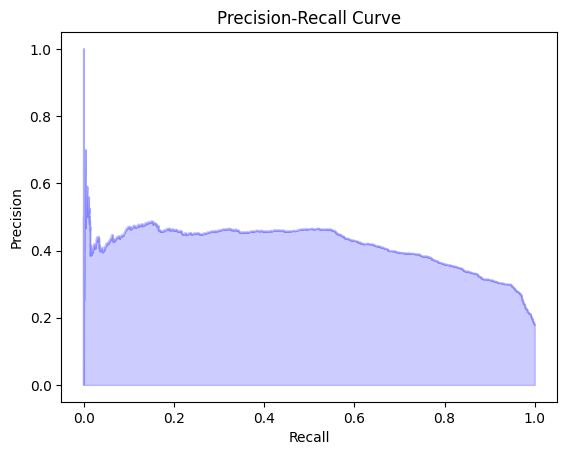

In [5]:
import os
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import precision_score, recall_score, f1_score, hamming_loss, precision_recall_curve, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import multilabel_confusion_matrix
from tabulate import tabulate

from google.colab import drive
# Mount Google Drive
drive.mount('/content/drive')

# Define paths
drive_path = '/content/drive/MyDrive'
test_preprocessed_dir = os.path.join(drive_path, 'CheXpert', 'aadhipreprocessedimages', 'test')
test_labels_csv = os.path.join(drive_path, 'CheXpert', 'aadhipreprocessedimages', 'modified_test_labels.csv')

# Load labels using Pandas
test_labels_df = pd.read_csv(test_labels_csv)

# Create data generator
test_datagen = ImageDataGenerator(rescale=1.0/255)
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_labels_df,
    directory=test_preprocessed_dir,
    x_col='Path',
    y_col=['No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity', 'Lung Lesion',
           'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis', 'Pneumothorax', 'Pleural Effusion',
           'Pleural Other', 'Fracture', 'Support Devices'],
    target_size=(256, 256),
    batch_size=32,
    class_mode='raw'
)

# Load the trained model (DenseNet-121)


# Load the saved model
loaded_model = load_model('/content/drive/MyDrive/CheXpert/aadhipreprocessedimages/NEW MODELS/resnet34_model_augmented.h5')

print("Model loaded successfully.")

print(f"Model loaded from /content/drive/MyDrive/CheXpert/aadhipreprocessedimages/NEW MODELS/resnet34_model_augmented.h5")

# Evaluate the model
y_true = test_labels_df.iloc[:, 1:].values
y_pred = loaded_model.predict(test_generator, steps=len(test_generator), verbose=1)
y_pred_binary = (y_pred > 0.5).astype(int)

# Calculate metrics
accuracy = (y_pred_binary == y_true).mean()
specificity = (y_pred_binary[~y_true.astype(bool)] == y_true[~y_true.astype(bool)]).mean()
precision_micro = precision_score(y_true, y_pred_binary, average='micro')
recall_micro = recall_score(y_true, y_pred_binary, average='micro')
f1_per_label = f1_score(y_true, y_pred_binary, average=None)
total_f1 = f1_score(y_true, y_pred_binary, average='macro')
hl = hamming_loss(y_true, y_pred_binary)

# Display metrics in a table
metrics_table_data = [['Metric', 'Value'],
                      ['Accuracy', f'{accuracy:.2%}'],
                      ['Specificity', f'{specificity:.2%}'],
                      ['Precision (Micro)', f'{precision_micro:.2%}'],
                      ['Recall (Micro)', f'{recall_micro:.2%}'],
                      ['Total F1-Score', f'{total_f1:.2%}'],
                      ['Hamming Loss', f'{hl:.2%}']]

# Print the metrics table using tabulate
metrics_table = tabulate(metrics_table_data, headers='firstrow', tablefmt='fancy_grid')
print(metrics_table)



# Calculate precision-recall curve per label
precision, recall, _ = precision_recall_curve(y_true.ravel(), y_pred.ravel())

# Plot the precision-recall curve
plt.figure()
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()


CONFUSION MATRIX

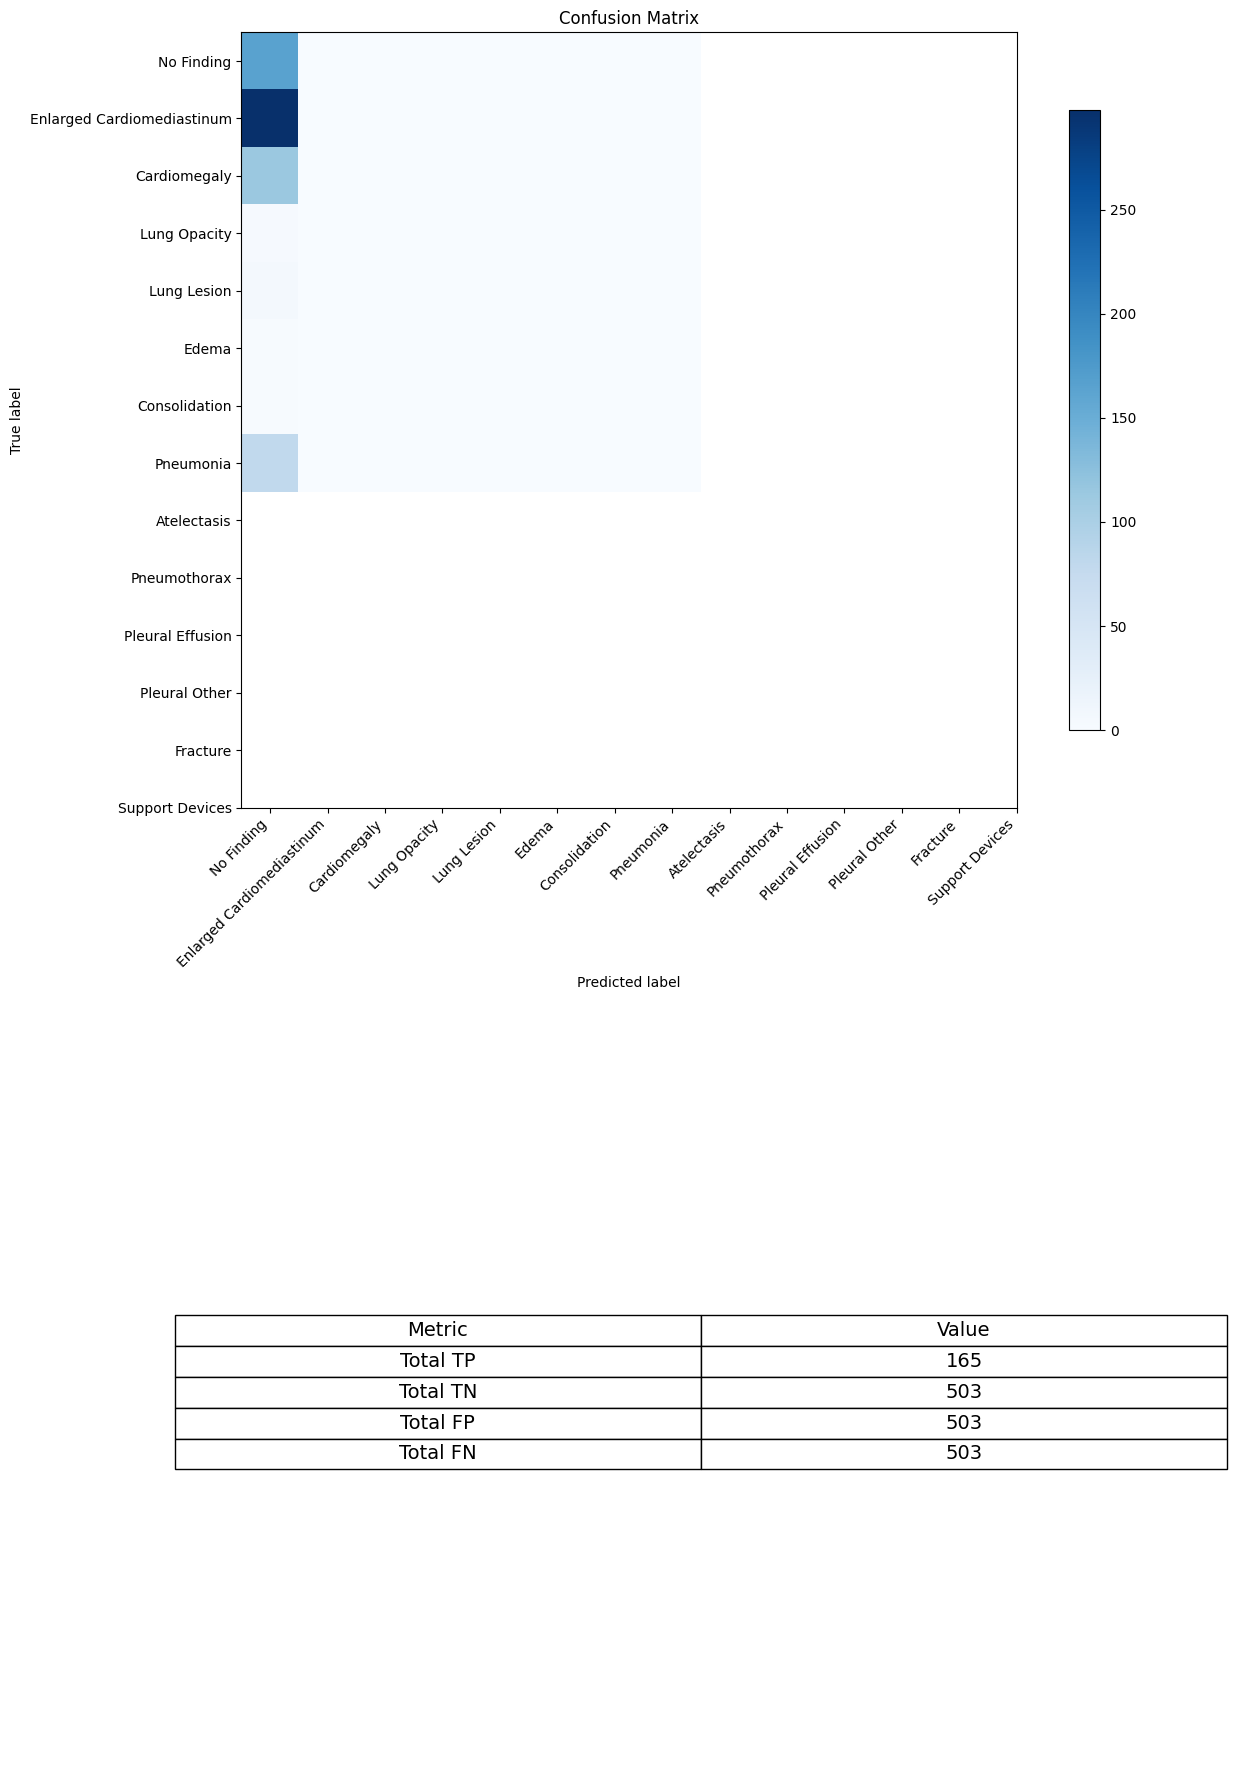

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Assuming you have calculated the confusion matrix correctly
# Using the 'confusion_mat' variable

class_names = ['No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity', 'Lung Lesion',
               'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis', 'Pneumothorax', 'Pleural Effusion',
               'Pleural Other', 'Fracture', 'Support Devices']

# Calculate TP, TN, FP, FN for the entire confusion matrix
total_TP = np.sum(np.diag(confusion_mat))
total_TN = np.sum(confusion_mat) - total_TP
total_FP = np.sum(confusion_mat, axis=0) - np.diag(confusion_mat)
total_FN = np.sum(confusion_mat, axis=1) - np.diag(confusion_mat)

# Create a figure with subplots
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 18))

# Display confusion matrix heatmap
ax_confusion = axes[0]
im = ax_confusion.imshow(confusion_mat, interpolation='nearest', cmap=plt.cm.Blues)
ax_confusion.set_title('Confusion Matrix')
ax_confusion.set_xticks(np.arange(len(class_names)))
ax_confusion.set_yticks(np.arange(len(class_names)))
ax_confusion.set_xticklabels(class_names, rotation=45, ha='right')
ax_confusion.set_yticklabels(class_names)
ax_confusion.set_ylabel('True label')
ax_confusion.set_xlabel('Predicted label')
plt.colorbar(im, ax=ax_confusion, shrink=0.8)  # Adjust the colorbar size

# Display total TP, TN, FP, FN values as a table
ax_table = axes[1]
table_data = [['Metric', 'Value'],
              ['Total TP', total_TP],
              ['Total TN', total_TN],
              ['Total FP', total_FP.sum()],
              ['Total FN', total_FN.sum()]]

# Create a table
table = ax_table.table(cellText=table_data, colLabels=None, cellLoc='center', loc='center')
table.auto_set_font_size(False)
table.set_fontsize(14)
table.scale(1, 1.5)

ax_table.axis('off')

plt.tight_layout()
plt.show()


RESNET-50

MODEL TRAINING

In [ ]:
import os
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import precision_score, recall_score, f1_score

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Define paths
drive_path = '/content/drive/MyDrive'
test_preprocessed_dir = os.path.join(drive_path, 'CheXpert', 'aadhipreprocessedimages', 'test')
val_preprocessed_dir = os.path.join(drive_path, 'CheXpert', 'aadhipreprocessedimages', 'val')
test_labels_csv = os.path.join(drive_path, 'CheXpert', 'aadhipreprocessedimages', 'modified_test_labels.csv')
val_labels_csv = os.path.join(drive_path, 'CheXpert', 'aadhipreprocessedimages', 'modified_val_labels.csv')

# Load labels using Pandas
test_labels_df = pd.read_csv(test_labels_csv)
val_labels_df = pd.read_csv(val_labels_csv)

# Create data generators with data augmentation
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1.0/255)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=test_labels_df,
    directory=test_preprocessed_dir,
    x_col='Path',
    y_col=['No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity', 'Lung Lesion',
           'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis', 'Pneumothorax', 'Pleural Effusion',
           'Pleural Other', 'Fracture', 'Support Devices'],
    target_size=(256, 256),
    batch_size=32,
    class_mode='raw'
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_labels_df,
    directory=val_preprocessed_dir,
    x_col='Path',
    y_col=['No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity', 'Lung Lesion',
           'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis', 'Pneumothorax', 'Pleural Effusion',
           'Pleural Other', 'Fracture', 'Support Devices'],
    target_size=(256, 256),
    batch_size=32,
    class_mode='raw'
)

# Create data generator with augmentation
augmented_train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    brightness_range=[0.8, 1.2],
    horizontal_flip=True,
    fill_mode='nearest'
)

# Use the augmented data generator for training
augmented_train_generator = augmented_train_datagen.flow_from_dataframe(
    dataframe=test_labels_df,  # or val_labels_df
    directory=test_preprocessed_dir,  # or val_preprocessed_dir
    x_col='Path',
    y_col=['No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity', 'Lung Lesion',
           'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis', 'Pneumothorax', 'Pleural Effusion',
           'Pleural Other', 'Fracture', 'Support Devices'],  # List of target class columns
    target_size=(256, 256),
    batch_size=32,
    class_mode='raw'
)

# Load and compile the ResNet-50 model with fine-tuning
base_model = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(256, 256, 3)
)

for layer in base_model.layers[-30:]:
    layer.trainable = True



# Add Dropout for regularization
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)  # Add dropout
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)  # Add dropout
predictions = Dense(14, activation='sigmoid')(x)



model = Model(inputs=base_model.input, outputs=predictions)

# Define a learning rate scheduler
def lr_schedule(epoch):
    if epoch < 10:
        return 0.001
    elif epoch < 30:
        return 0.0001
    else:
        return 0.00001


# Compile the model with Adam optimizer and binary cross-entropy loss
clipped_optimizer = tf.keras.optimizers.Adam(clipvalue=0.5)
model.compile(optimizer=clipped_optimizer, loss='binary_crossentropy', metrics=['accuracy'])


# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with learning rate scheduler, early stopping, and augmented data
augmented_epochs = 50  # You can adjust this number as needed
history = model.fit(
    augmented_train_generator,
    steps_per_epoch=len(augmented_train_generator),
    epochs=augmented_epochs,
    validation_data=val_generator,
    validation_steps=len(val_generator),
    callbacks=[LearningRateScheduler(lr_schedule), early_stopping]
)


# Save the trained model
model_save_path = '/content/drive/MyDrive/CheXpert/aadhipreprocessedimages/NEW MODELS/resnet50_model_augmented.h5'
model.save(model_save_path)

print(f"Model saved to {model_save_path}")

EVALUATION

In [ ]:
import os
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import precision_score, recall_score, f1_score, hamming_loss, precision_recall_curve, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import multilabel_confusion_matrix
from tabulate import tabulate

from google.colab import drive
# Mount Google Drive
drive.mount('/content/drive')

# Define paths
drive_path = '/content/drive/MyDrive'
test_preprocessed_dir = os.path.join(drive_path, 'CheXpert', 'aadhipreprocessedimages', 'test')
test_labels_csv = os.path.join(drive_path, 'CheXpert', 'aadhipreprocessedimages', 'modified_test_labels.csv')

# Load labels using Pandas
test_labels_df = pd.read_csv(test_labels_csv)

# Create data generator
test_datagen = ImageDataGenerator(rescale=1.0/255)
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_labels_df,
    directory=test_preprocessed_dir,
    x_col='Path',
    y_col=['No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity', 'Lung Lesion',
           'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis', 'Pneumothorax', 'Pleural Effusion',
           'Pleural Other', 'Fracture', 'Support Devices'],
    target_size=(256, 256),
    batch_size=32,
    class_mode='raw'
)




# Load the saved model
loaded_model = load_model('/content/drive/MyDrive/CheXpert/aadhipreprocessedimages/NEW MODELS/resnet50_model_augmented.h5')

print("Model loaded successfully.")

print(f"Model loaded from {model_save_path}")

# Evaluate the model
y_true = test_labels_df.iloc[:, 1:].values
y_pred = loaded_model.predict(test_generator, steps=len(test_generator), verbose=1)
y_pred_binary = (y_pred > 0.5).astype(int)

# Calculate metrics
accuracy = (y_pred_binary == y_true).mean()
specificity = (y_pred_binary[~y_true.astype(bool)] == y_true[~y_true.astype(bool)]).mean()
precision_micro = precision_score(y_true, y_pred_binary, average='micro')
recall_micro = recall_score(y_true, y_pred_binary, average='micro')
f1_per_label = f1_score(y_true, y_pred_binary, average=None)
total_f1 = f1_score(y_true, y_pred_binary, average='macro')
hl = hamming_loss(y_true, y_pred_binary)

# Display metrics in a table
metrics_table_data = [['Metric', 'Value'],
                      ['Accuracy', f'{accuracy:.2%}'],
                      ['Specificity', f'{specificity:.2%}'],
                      ['Precision (Micro)', f'{precision_micro:.2%}'],
                      ['Recall (Micro)', f'{recall_micro:.2%}'],
                      ['Total F1-Score', f'{total_f1:.2%}'],
                      ['Hamming Loss', f'{hl:.2%}']]

# Print the metrics table using tabulate
metrics_table = tabulate(metrics_table_data, headers='firstrow', tablefmt='fancy_grid')
print(metrics_table)



# Calculate precision-recall curve per label
precision, recall, _ = precision_recall_curve(y_true.ravel(), y_pred.ravel())

# Plot the precision-recall curve
plt.figure()
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

CONFUSION MATRIX

In [ ]:
class_names = ['No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity', 'Lung Lesion',
               'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis', 'Pneumothorax', 'Pleural Effusion',
               'Pleural Other', 'Fracture', 'Support Devices']

# Convert multilabel predictions to multiclass predictions
y_true_classes = np.argmax(y_true, axis=1)
y_pred_classes = np.argmax(y_pred_binary, axis=1)

# Calculate confusion matrix
confusion_mat = confusion_matrix(y_true_classes, y_pred_classes)

# Calculate TP, TN, FP, FN for the entire confusion matrix
total_TP = np.sum(np.diag(confusion_mat))
total_TN = np.sum(confusion_mat) - total_TP
total_FP = np.sum(confusion_mat, axis=0) - np.diag(confusion_mat)
total_FN = np.sum(confusion_mat, axis=1) - np.diag(confusion_mat)

# Create a figure with subplots
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 18))

# Display confusion matrix heatmap
ax_confusion = axes[0]
im = ax_confusion.imshow(confusion_mat, interpolation='nearest', cmap=plt.cm.Blues)
ax_confusion.set_title('Confusion Matrix')
ax_confusion.set_xticks(np.arange(len(class_names)))
ax_confusion.set_yticks(np.arange(len(class_names)))
ax_confusion.set_xticklabels(class_names, rotation=45, ha='right')
ax_confusion.set_yticklabels(class_names)
ax_confusion.set_ylabel('True label')
ax_confusion.set_xlabel('Predicted label')
plt.colorbar(im, ax=ax_confusion, shrink=0.8)  # Adjust the colorbar size

# Display total TP, TN, FP, FN values as a table
ax_table = axes[1]
table_data = [['Metric', 'Value'],
              ['Total TP', total_TP],
              ['Total TN', total_TN],
              ['Total FP', total_FP.sum()],
              ['Total FN', total_FN.sum()]]

ax_table.axis('off')
ax_table.table(cellText=table_data, colLabels=None, cellLoc='center', loc='center')

plt.tight_layout()
plt.show()

RESNET-101

MODEL TRAINING

In [ ]:


import os
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet101
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import precision_score, recall_score, f1_score

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Define paths
drive_path = '/content/drive/MyDrive'
test_preprocessed_dir = os.path.join(drive_path, 'CheXpert', 'aadhipreprocessedimages', 'test')
val_preprocessed_dir = os.path.join(drive_path, 'CheXpert', 'aadhipreprocessedimages', 'val')
test_labels_csv = os.path.join(drive_path, 'CheXpert', 'aadhipreprocessedimages', 'modified_test_labels.csv')
val_labels_csv = os.path.join(drive_path, 'CheXpert', 'aadhipreprocessedimages', 'modified_val_labels.csv')

# Load labels using Pandas
test_labels_df = pd.read_csv(test_labels_csv)
val_labels_df = pd.read_csv(val_labels_csv)

# Create data generators with data augmentation
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1.0/255)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=test_labels_df,
    directory=test_preprocessed_dir,
    x_col='Path',
    y_col=['No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity', 'Lung Lesion',
           'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis', 'Pneumothorax', 'Pleural Effusion',
           'Pleural Other', 'Fracture', 'Support Devices'],
    target_size=(256, 256),
    batch_size=32,
    class_mode='raw'
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_labels_df,
    directory=val_preprocessed_dir,
    x_col='Path',
    y_col=['No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity', 'Lung Lesion',
           'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis', 'Pneumothorax', 'Pleural Effusion',
           'Pleural Other', 'Fracture', 'Support Devices'],
    target_size=(256, 256),
    batch_size=32,
    class_mode='raw'
)

# Create data generator with augmentation
augmented_train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    brightness_range=[0.8, 1.2],
    horizontal_flip=True,
    fill_mode='nearest'
)

# Use the augmented data generator for training
augmented_train_generator = augmented_train_datagen.flow_from_dataframe(
    dataframe=test_labels_df,  # or val_labels_df
    directory=test_preprocessed_dir,  # or val_preprocessed_dir
    x_col='Path',
    y_col=['No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity', 'Lung Lesion',
           'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis', 'Pneumothorax', 'Pleural Effusion',
           'Pleural Other', 'Fracture', 'Support Devices'],  # List of target class columns
    target_size=(256, 256),
    batch_size=32,
    class_mode='raw'
)

# Load and compile the ResNet-101 model with fine-tuning
base_model = ResNet101(
    weights='imagenet',
    include_top=False,
    input_shape=(256, 256, 3)
)

for layer in base_model.layers[-30:]:
    layer.trainable = True

# Rest of the code remains the same




# Add Dropout for regularization
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)  # Add dropout
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)  # Add dropout
predictions = Dense(14, activation='sigmoid')(x)



model = Model(inputs=base_model.input, outputs=predictions)

# Define a learning rate scheduler
def lr_schedule(epoch):
    if epoch < 10:
        return 0.001
    elif epoch < 30:
        return 0.0001
    else:
        return 0.00001


# Compile the model with Adam optimizer and binary cross-entropy loss
clipped_optimizer = tf.keras.optimizers.Adam(clipvalue=0.5)
model.compile(optimizer=clipped_optimizer, loss='binary_crossentropy', metrics=['accuracy'])


# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with learning rate scheduler, early stopping, and augmented data
# Train the model with learning rate scheduler, early stopping, and augmented data
augmented_epochs = 50  # You can adjust this number as needed
history = model.fit(
    augmented_train_generator,
    steps_per_epoch=len(augmented_train_generator),
    epochs=augmented_epochs,
    validation_data=val_generator,
    validation_steps=len(val_generator),
    callbacks=[LearningRateScheduler(lr_schedule), early_stopping]
)

# Save the trained model
model_save_path = '/content/drive/MyDrive/CheXpert/aadhipreprocessedimages/NEW MODELS/resnet101_model_augmented.h5'
model.save(model_save_path)

print(f"Model saved to {model_save_path}")

EVALUATION

In [ ]:
import os
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import precision_score, recall_score, f1_score, hamming_loss, precision_recall_curve, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import multilabel_confusion_matrix
from tabulate import tabulate

from google.colab import drive
# Mount Google Drive
drive.mount('/content/drive')

# Define paths
drive_path = '/content/drive/MyDrive'
test_preprocessed_dir = os.path.join(drive_path, 'CheXpert', 'aadhipreprocessedimages', 'test')
test_labels_csv = os.path.join(drive_path, 'CheXpert', 'aadhipreprocessedimages', 'modified_test_labels.csv')

# Load labels using Pandas
test_labels_df = pd.read_csv(test_labels_csv)

# Create data generator
test_datagen = ImageDataGenerator(rescale=1.0/255)
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_labels_df,
    directory=test_preprocessed_dir,
    x_col='Path',
    y_col=['No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity', 'Lung Lesion',
           'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis', 'Pneumothorax', 'Pleural Effusion',
           'Pleural Other', 'Fracture', 'Support Devices'],
    target_size=(256, 256),
    batch_size=32,
    class_mode='raw'
)




# Load the saved model
loaded_model = load_model('/content/drive/MyDrive/CheXpert/aadhipreprocessedimages/NEW MODELS/resnet101_model_augmented.h5')

print("Model loaded successfully.")

print(f"Model loaded from /content/drive/MyDrive/CheXpert/aadhipreprocessedimages/NEW MODELS/resnet101_model_augmented.h5")

# Evaluate the model
y_true = test_labels_df.iloc[:, 1:].values
y_pred = loaded_model.predict(test_generator, steps=len(test_generator), verbose=1)
y_pred_binary = (y_pred > 0.5).astype(int)

# Calculate metrics
accuracy = (y_pred_binary == y_true).mean()
specificity = (y_pred_binary[~y_true.astype(bool)] == y_true[~y_true.astype(bool)]).mean()
precision_micro = precision_score(y_true, y_pred_binary, average='micro')
recall_micro = recall_score(y_true, y_pred_binary, average='micro')
f1_per_label = f1_score(y_true, y_pred_binary, average=None)
total_f1 = f1_score(y_true, y_pred_binary, average='macro')
hl = hamming_loss(y_true, y_pred_binary)

# Display metrics in a table
metrics_table_data = [['Metric', 'Value'],
                      ['Accuracy', f'{accuracy:.2%}'],
                      ['Specificity', f'{specificity:.2%}'],
                      ['Precision (Micro)', f'{precision_micro:.2%}'],
                      ['Recall (Micro)', f'{recall_micro:.2%}'],
                      ['Total F1-Score', f'{total_f1:.2%}'],
                      ['Hamming Loss', f'{hl:.2%}']]

# Print the metrics table using tabulate
metrics_table = tabulate(metrics_table_data, headers='firstrow', tablefmt='fancy_grid')
print(metrics_table)



# Calculate precision-recall curve per label
precision, recall, _ = precision_recall_curve(y_true.ravel(), y_pred.ravel())

# Plot the precision-recall curve
plt.figure()
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

CONFUSION MATRIX

In [ ]:
class_names = ['No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity', 'Lung Lesion',
               'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis', 'Pneumothorax', 'Pleural Effusion',
               'Pleural Other', 'Fracture', 'Support Devices']

# Convert multilabel predictions to multiclass predictions
y_true_classes = np.argmax(y_true, axis=1)
y_pred_classes = np.argmax(y_pred_binary, axis=1)

# Calculate confusion matrix
confusion_mat = confusion_matrix(y_true_classes, y_pred_classes)

# Calculate TP, TN, FP, FN for the entire confusion matrix
total_TP = np.sum(np.diag(confusion_mat))
total_TN = np.sum(confusion_mat) - total_TP
total_FP = np.sum(confusion_mat, axis=0) - np.diag(confusion_mat)
total_FN = np.sum(confusion_mat, axis=1) - np.diag(confusion_mat)

# Create a figure with subplots
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 18))

# Display confusion matrix heatmap
ax_confusion = axes[0]
im = ax_confusion.imshow(confusion_mat, interpolation='nearest', cmap=plt.cm.Blues)
ax_confusion.set_title('Confusion Matrix')
ax_confusion.set_xticks(np.arange(len(class_names)))
ax_confusion.set_yticks(np.arange(len(class_names)))
ax_confusion.set_xticklabels(class_names, rotation=45, ha='right')
ax_confusion.set_yticklabels(class_names)
ax_confusion.set_ylabel('True label')
ax_confusion.set_xlabel('Predicted label')
plt.colorbar(im, ax=ax_confusion, shrink=0.8)  # Adjust the colorbar size

# Display total TP, TN, FP, FN values as a table
ax_table = axes[1]
table_data = [['Metric', 'Value'],
              ['Total TP', total_TP],
              ['Total TN', total_TN],
              ['Total FP', total_FP.sum()],
              ['Total FN', total_FN.sum()]]

ax_table.axis('off')
ax_table.table(cellText=table_data, colLabels=None, cellLoc='center', loc='center')

plt.tight_layout()
plt.show()

DENSENET-121

MODEL TRAINING

In [ ]:
import os
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import precision_score, recall_score, f1_score

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Define paths
drive_path = '/content/drive/MyDrive'
test_preprocessed_dir = os.path.join(drive_path, 'CheXpert', 'aadhipreprocessedimages', 'test')
val_preprocessed_dir = os.path.join(drive_path, 'CheXpert', 'aadhipreprocessedimages', 'val')
test_labels_csv = os.path.join(drive_path, 'CheXpert', 'aadhipreprocessedimages', 'modified_test_labels.csv')
val_labels_csv = os.path.join(drive_path, 'CheXpert', 'aadhipreprocessedimages', 'modified_val_labels.csv')

# Load labels using Pandas
test_labels_df = pd.read_csv(test_labels_csv)
val_labels_df = pd.read_csv(val_labels_csv)

# Create data generators with data augmentation
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1.0/255)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=test_labels_df,
    directory=test_preprocessed_dir,
    x_col='Path',
    y_col=['No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity', 'Lung Lesion',
           'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis', 'Pneumothorax', 'Pleural Effusion',
           'Pleural Other', 'Fracture', 'Support Devices'],
    target_size=(256, 256),
    batch_size=32,
    class_mode='raw'
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_labels_df,
    directory=val_preprocessed_dir,
    x_col='Path',
    y_col=['No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity', 'Lung Lesion',
           'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis', 'Pneumothorax', 'Pleural Effusion',
           'Pleural Other', 'Fracture', 'Support Devices'],
    target_size=(256, 256),
    batch_size=32,
    class_mode='raw'
)

# Create data generator with augmentation
augmented_train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    brightness_range=[0.8, 1.2],
    horizontal_flip=True,
    fill_mode='nearest'
)

# Use the augmented data generator for training
augmented_train_generator = augmented_train_datagen.flow_from_dataframe(
    dataframe=test_labels_df,  # or val_labels_df
    directory=test_preprocessed_dir,  # or val_preprocessed_dir
    x_col='Path',
    y_col=['No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity', 'Lung Lesion',
           'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis', 'Pneumothorax', 'Pleural Effusion',
           'Pleural Other', 'Fracture', 'Support Devices'],  # List of target class columns
    target_size=(256, 256),
    batch_size=32,
    class_mode='raw'
)

# Load and compile the DenseNet-121 model with fine-tuning
base_model = DenseNet121(
    weights='imagenet',
    include_top=False,
    input_shape=(256, 256, 3)
)

for layer in base_model.layers[-30:]:
    layer.trainable = True



# Add Dropout for regularization
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)  # Add dropout
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)  # Add dropout
predictions = Dense(14, activation='sigmoid')(x)



model = Model(inputs=base_model.input, outputs=predictions)

# Define a learning rate scheduler
def lr_schedule(epoch):
    if epoch < 10:
        return 0.001
    elif epoch < 30:
        return 0.0001
    else:
        return 0.00001

# Compile the model with Adam optimizer and binary cross-entropy loss
clipped_optimizer = tf.keras.optimizers.Adam(clipvalue=0.5)
model.compile(optimizer=clipped_optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with learning rate scheduler, early stopping, and augmented data
augmented_epochs = 50  # You can adjust this number as needed
history = model.fit(
    augmented_train_generator,
    steps_per_epoch=len(augmented_train_generator),
    epochs=augmented_epochs,
    validation_data=val_generator,
    validation_steps=len(val_generator),
    callbacks=[LearningRateScheduler(lr_schedule), early_stopping]
)


# Save the trained model
model_save_path = '/content/drive/MyDrive/CheXpert/aadhipreprocessedimages/NEW MODELS/densenet121_model_augmented.h5'
model.save(model_save_path)

print(f"Model saved to {model_save_path}")

EVALUATION

In [ ]:
import os
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import precision_score, recall_score, f1_score, hamming_loss, precision_recall_curve, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import multilabel_confusion_matrix
from tabulate import tabulate
from keras.models import load_model


from google.colab import drive
# Mount Google Drive
drive.mount('/content/drive')

# Define paths
drive_path = '/content/drive/MyDrive'
test_preprocessed_dir = os.path.join(drive_path, 'CheXpert', 'aadhipreprocessedimages', 'test')
test_labels_csv = os.path.join(drive_path, 'CheXpert', 'aadhipreprocessedimages', 'modified_test_labels.csv')

# Load labels using Pandas
test_labels_df = pd.read_csv(test_labels_csv)

# Create data generator
test_datagen = ImageDataGenerator(rescale=1.0/255)
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_labels_df,
    directory=test_preprocessed_dir,
    x_col='Path',
    y_col=['No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity', 'Lung Lesion',
           'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis', 'Pneumothorax', 'Pleural Effusion',
           'Pleural Other', 'Fracture', 'Support Devices'],
    target_size=(256, 256),
    batch_size=32,
    class_mode='raw'
)

# Load the trained model (DenseNet-121)


model_save_path = '/content/drive/MyDrive/CheXpert/aadhipreprocessedimages/NEW MODELS/densenet121_model_augmented.h5'

loaded_model = load_model(model_save_path)

print("Model loaded successfully.")

print(f"Model loaded from {model_save_path}")

# Evaluate the model
y_true = test_labels_df.iloc[:, 1:].values
y_pred = loaded_model.predict(test_generator, steps=len(test_generator), verbose=1)
y_pred_binary = (y_pred > 0.5).astype(int)

# Calculate metrics
accuracy = (y_pred_binary == y_true).mean()
specificity = (y_pred_binary[~y_true.astype(bool)] == y_true[~y_true.astype(bool)]).mean()
precision_micro = precision_score(y_true, y_pred_binary, average='micro')
recall_micro = recall_score(y_true, y_pred_binary, average='micro')
f1_per_label = f1_score(y_true, y_pred_binary, average=None)
total_f1 = f1_score(y_true, y_pred_binary, average='macro')
hl = hamming_loss(y_true, y_pred_binary)

# Display metrics in a table
metrics_table_data = [['Metric', 'Value'],
                      ['Accuracy', f'{accuracy:.2%}'],
                      ['Specificity', f'{specificity:.2%}'],
                      ['Precision (Micro)', f'{precision_micro:.2%}'],
                      ['Recall (Micro)', f'{recall_micro:.2%}'],
                      ['Total F1-Score', f'{total_f1:.2%}'],
                      ['Hamming Loss', f'{hl:.2%}']]

# Print the metrics table using tabulate
metrics_table = tabulate(metrics_table_data, headers='firstrow', tablefmt='fancy_grid')
print(metrics_table)



# Calculate precision-recall curve per label
precision, recall, _ = precision_recall_curve(y_true.ravel(), y_pred.ravel())

# Plot the precision-recall curve
plt.figure()
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

CONFUSION MATRIX

In [ ]:
class_names = ['No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity', 'Lung Lesion',
               'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis', 'Pneumothorax', 'Pleural Effusion',
               'Pleural Other', 'Fracture', 'Support Devices']

# Convert multilabel predictions to multiclass predictions
y_true_classes = np.argmax(y_true, axis=1)
y_pred_classes = np.argmax(y_pred_binary, axis=1)

# Calculate confusion matrix
confusion_mat = confusion_matrix(y_true_classes, y_pred_classes)

# Calculate TP, TN, FP, FN for the entire confusion matrix
total_TP = np.sum(np.diag(confusion_mat))
total_TN = np.sum(confusion_mat) - total_TP
total_FP = np.sum(confusion_mat, axis=0) - np.diag(confusion_mat)
total_FN = np.sum(confusion_mat, axis=1) - np.diag(confusion_mat)

# Create a figure with subplots
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 18))

# Display confusion matrix heatmap
ax_confusion = axes[0]
im = ax_confusion.imshow(confusion_mat, interpolation='nearest', cmap=plt.cm.Blues)
ax_confusion.set_title('Confusion Matrix')
ax_confusion.set_xticks(np.arange(len(class_names)))
ax_confusion.set_yticks(np.arange(len(class_names)))
ax_confusion.set_xticklabels(class_names, rotation=45, ha='right')
ax_confusion.set_yticklabels(class_names)
ax_confusion.set_ylabel('True label')
ax_confusion.set_xlabel('Predicted label')
plt.colorbar(im, ax=ax_confusion, shrink=0.8)  # Adjust the colorbar size

# Display total TP, TN, FP, FN values as a table
ax_table = axes[1]
table_data = [['Metric', 'Value'],
              ['Total TP', total_TP],
              ['Total TN', total_TN],
              ['Total FP', total_FP.sum()],
              ['Total FN', total_FN.sum()]]

ax_table.axis('off')
ax_table.table(cellText=table_data, colLabels=None, cellLoc='center', loc='center')

plt.tight_layout()
plt.show()

MOBILENET

MODEL TRAINING

In [ ]:
import os
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import precision_score, recall_score, f1_score




# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Define paths
drive_path = '/content/drive/MyDrive'
test_preprocessed_dir = os.path.join(drive_path, 'CheXpert', 'aadhipreprocessedimages', 'test')
val_preprocessed_dir = os.path.join(drive_path, 'CheXpert', 'aadhipreprocessedimages', 'val')
test_labels_csv = os.path.join(drive_path, 'CheXpert', 'aadhipreprocessedimages', 'modified_test_labels.csv')
val_labels_csv = os.path.join(drive_path, 'CheXpert', 'aadhipreprocessedimages', 'modified_val_labels.csv')

# Load labels using Pandas
test_labels_df = pd.read_csv(test_labels_csv)
val_labels_df = pd.read_csv(val_labels_csv)

# Create data generators with data augmentation
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1.0/255)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=test_labels_df,
    directory=test_preprocessed_dir,
    x_col='Path',
    y_col=['No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity', 'Lung Lesion',
           'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis', 'Pneumothorax', 'Pleural Effusion',
           'Pleural Other', 'Fracture', 'Support Devices'],
    target_size=(256, 256),
    batch_size=32,
    class_mode='raw'
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_labels_df,
    directory=val_preprocessed_dir,
    x_col='Path',
    y_col=['No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity', 'Lung Lesion',
           'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis', 'Pneumothorax', 'Pleural Effusion',
           'Pleural Other', 'Fracture', 'Support Devices'],
    target_size=(256, 256),
    batch_size=32,
    class_mode='raw'
)

# Create data generator with augmentation
augmented_train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    brightness_range=[0.8, 1.2],
    horizontal_flip=True,
    fill_mode='nearest'
)

# Use the augmented data generator for training
augmented_train_generator = augmented_train_datagen.flow_from_dataframe(
    dataframe=test_labels_df,  # or val_labels_df
    directory=test_preprocessed_dir,  # or val_preprocessed_dir
    x_col='Path',
    y_col=['No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity', 'Lung Lesion',
           'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis', 'Pneumothorax', 'Pleural Effusion',
           'Pleural Other', 'Fracture', 'Support Devices'],  # List of target class columns
    target_size=(256, 256),
    batch_size=32,
    class_mode='raw'
)

base_model = MobileNet(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

for layer in base_model.layers[:-30]:
    layer.trainable = False

# Add Dropout for regularization
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)  # Add dropout
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)  # Add dropout
predictions = Dense(14, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)




# Define a learning rate scheduler
def lr_schedule(epoch):
    if epoch < 10:
        return 0.001
    elif epoch < 30:
        return 0.0001
    else:
        return 0.00001


# Compile the model with Adam optimizer and binary cross-entropy loss
clipped_optimizer = tf.keras.optimizers.Adam(clipvalue=0.5)
model.compile(optimizer=clipped_optimizer, loss='binary_crossentropy', metrics=['accuracy'])


# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with learning rate scheduler, early stopping, and augmented data
augmented_epochs = 50  # You can adjust this number as needed
history = model.fit(
    augmented_train_generator,
    steps_per_epoch=len(augmented_train_generator),
    epochs=augmented_epochs,
    validation_data=val_generator,
    validation_steps=len(val_generator),
    callbacks=[LearningRateScheduler(lr_schedule), early_stopping]
)


# Save the trained model
model_save_path = '/content/drive/MyDrive/CheXpert/aadhipreprocessedimages/NEW MODELS/mobilenet_model_augmented.h5'
model.save(model_save_path)

print(f"Model saved to {model_save_path}")

EVALUATION

In [ ]:
import os
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import precision_score, recall_score, f1_score, hamming_loss, precision_recall_curve, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import multilabel_confusion_matrix
from tabulate import tabulate

from google.colab import drive
# Mount Google Drive
drive.mount('/content/drive')

# Define paths
drive_path = '/content/drive/MyDrive'
test_preprocessed_dir = os.path.join(drive_path, 'CheXpert', 'aadhipreprocessedimages', 'test')
test_labels_csv = os.path.join(drive_path, 'CheXpert', 'aadhipreprocessedimages', 'modified_test_labels.csv')

# Load labels using Pandas
test_labels_df = pd.read_csv(test_labels_csv)

# Create data generator
test_datagen = ImageDataGenerator(rescale=1.0/255)
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_labels_df,
    directory=test_preprocessed_dir,
    x_col='Path',
    y_col=['No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity', 'Lung Lesion',
           'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis', 'Pneumothorax', 'Pleural Effusion',
           'Pleural Other', 'Fracture', 'Support Devices'],
    target_size=(256, 256),
    batch_size=32,
    class_mode='raw'
)




# Load the saved model
loaded_model = load_model('/content/drive/MyDrive/CheXpert/aadhipreprocessedimages/NEW MODELS/mobilenet_model_augmented.h5')

print("Model loaded successfully.")

print(f"Model loaded from {model_save_path}")

# Evaluate the model
y_true = test_labels_df.iloc[:, 1:].values
y_pred = loaded_model.predict(test_generator, steps=len(test_generator), verbose=1)
y_pred_binary = (y_pred > 0.5).astype(int)

# Calculate metrics
accuracy = (y_pred_binary == y_true).mean()
specificity = (y_pred_binary[~y_true.astype(bool)] == y_true[~y_true.astype(bool)]).mean()
precision_micro = precision_score(y_true, y_pred_binary, average='micro')
recall_micro = recall_score(y_true, y_pred_binary, average='micro')
f1_per_label = f1_score(y_true, y_pred_binary, average=None)
total_f1 = f1_score(y_true, y_pred_binary, average='macro')
hl = hamming_loss(y_true, y_pred_binary)

# Display metrics in a table
metrics_table_data = [['Metric', 'Value'],
                      ['Accuracy', f'{accuracy:.2%}'],
                      ['Specificity', f'{specificity:.2%}'],
                      ['Precision (Micro)', f'{precision_micro:.2%}'],
                      ['Recall (Micro)', f'{recall_micro:.2%}'],
                      ['Total F1-Score', f'{total_f1:.2%}'],
                      ['Hamming Loss', f'{hl:.2%}']]

# Print the metrics table using tabulate
metrics_table = tabulate(metrics_table_data, headers='firstrow', tablefmt='fancy_grid')
print(metrics_table)



# Calculate precision-recall curve per label
precision, recall, _ = precision_recall_curve(y_true.ravel(), y_pred.ravel())

# Plot the precision-recall curve
plt.figure()
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

CONFUSION MATRIX

In [ ]:
class_names = ['No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity', 'Lung Lesion',
               'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis', 'Pneumothorax', 'Pleural Effusion',
               'Pleural Other', 'Fracture', 'Support Devices']

# Convert multilabel predictions to multiclass predictions
y_true_classes = np.argmax(y_true, axis=1)
y_pred_classes = np.argmax(y_pred_binary, axis=1)

# Calculate confusion matrix
confusion_mat = confusion_matrix(y_true_classes, y_pred_classes)

# Calculate TP, TN, FP, FN for the entire confusion matrix
total_TP = np.sum(np.diag(confusion_mat))
total_TN = np.sum(confusion_mat) - total_TP
total_FP = np.sum(confusion_mat, axis=0) - np.diag(confusion_mat)
total_FN = np.sum(confusion_mat, axis=1) - np.diag(confusion_mat)

# Create a figure with subplots
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 18))

# Display confusion matrix heatmap
ax_confusion = axes[0]
im = ax_confusion.imshow(confusion_mat, interpolation='nearest', cmap=plt.cm.Blues)
ax_confusion.set_title('Confusion Matrix')
ax_confusion.set_xticks(np.arange(len(class_names)))
ax_confusion.set_yticks(np.arange(len(class_names)))
ax_confusion.set_xticklabels(class_names, rotation=45, ha='right')
ax_confusion.set_yticklabels(class_names)
ax_confusion.set_ylabel('True label')
ax_confusion.set_xlabel('Predicted label')
plt.colorbar(im, ax=ax_confusion, shrink=0.8)  # Adjust the colorbar size

# Display total TP, TN, FP, FN values as a table
ax_table = axes[1]
table_data = [['Metric', 'Value'],
              ['Total TP', total_TP],
              ['Total TN', total_TN],
              ['Total FP', total_FP.sum()],
              ['Total FN', total_FN.sum()]]

ax_table.axis('off')
ax_table.table(cellText=table_data, colLabels=None, cellLoc='center', loc='center')

plt.tight_layout()
plt.show()